# Cross-modal (text and figures) Analysis of a Scientific Corpus from Semantic Scholar

## Overview

**Raul Ortega** (rortega@expertsystem.com)

**Jose Manuel Gomez-Perez** (jmgomez@expertsystem.com)

*Expert System (http://www.expertsystem.com) *


In this notebook we show the application of crossmodal techniques to improve the categorization of scientific papers through content related to figures, using both the textual part (captions) and the visual part (figures, diagrams, images) jointly. We show how the knowledge acquired by a classification model built on a CNN over textual data can be partially transferred to an equivalent model focused on figure classification following the VGG architecture. Several experiments are proposed that incrementally show how such correspondence between the textual and visual parts can be exploited to improve results.

## Initialization


The source code of this notebook is available in Github ( https://github.com/rortegaes/crossmodal_models ). We have four scripts:
1.   **data_loading**. To download and access to the corpus available in URL A ZENODO.
2.   **experiments**. To run the experiments.
3.   **models**. To generate the models.
4.   **qualitative**. To generate a qualitative analysis of the results



In [16]:
!rm -r tutorial

!git clone https://github.com/HybridNLP2018/tutorial.git
!cd tutorial
!apt -qq install -y graphviz && pip install -q pydot

from tutorial.scripts.crossmodal_analysis import data_loading
from tutorial.scripts.crossmodal_analysis import experiments
from tutorial.scripts.crossmodal_analysis import models
from tutorial.scripts.crossmodal_analysis import qualitative

from keras.utils.vis_utils import plot_model
import pydot
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

Cloning into 'tutorial'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 243 (delta 57), reused 80 (delta 28), pack-reused 132
Receiving objects: 100% (243/243), 19.69 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (117/117), done.
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [2]:
data_loading.file_download()

LOADING DATASETS AND MODEL WEIGHTS
BASELINE DATA AND WEIGHTS LOADED
EXPERIMENT #1 LOADED
EXPERIMENT #2 LOADED
EXPERIMENT #3 LOADED
EXPERIMENT #4 LOADED
EXPERIMENT #5 LOADED


## Hypothesis

* **H1**: **Both a figure and its caption can be categorized automatically based on its content with respect to an arbitrary taxonomy**. 
Previous work [1] shows how to apply CNN architectures to categorize a corpus of scientific papers using text that defines the content of an article based e.g. on paper title and  abstract. However, in this work we explore how the information contained in the visual material of an article (its figures, diagrams, charts, images) and, alternatively, related text (figure captions) allows to categorize scientific publications in analogous ways.

* **H2**: **The caption of a figure and the figure itself contain complementary knowledge**. 
As shown in previous investigation, e.g. [2], the knowledge provided by the different data modalities (text, images, video, etc.) is complementary and such complementarity can be leveraged. In the scientific domain, the utlity of such property is as shown e.g. in Figures 1 and 2. On one hand, Figure 1 shows how the caption of two very similar figures can make the difference in the task of distinguish the figure's scientific field. On the other hand, Figure 2 shows how visual information is necessary in order to distinguish what field it refers to, since certain words such as "injection" or "cavity" can be interpreted as words from the field of medicine or "locking plate" from the field of engineering, when just looking at the image we can easily distinguish that it is the opposite.

<table><tr><td><img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/Ejemplo-Buen-Caption.png?raw=true'><center>*Figure 1. Example of figures whose captions help to detect the scientific field of the image.*</center></td><td><img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/Ejemplo-Buenas-Figures.png?raw=true'><center>*Figure 2. Example of captions whose figures help to detect the scientific field of the image.*</center></td></tr></table>
 
* **H3**: **Knowledge can be transferred between uni-modal models as a consequence of cross-modal analysis (as of figure-caption)**. 
Previous work [3] proposed a mixed convolutional neuronal network with a visual and an audio part each following a VGG architecture , and ran an association task between both modalities, exploiting backpropagation. This  resulted in improved performance in each individual modality (video and audio in that case). If we are able to apply this to the scope of this research, specifically to the figure and its caption, it will be possible a transference of knowledge between both modalities.

* **H4**: **Knowledge transfer between modalities helps to improve scientific paper figure classification over a number of categories**. 
We show how such knowledge transfer across modalities impacts on the classification of figures contained scientific paper over a number of categories, taking into account the textual part (caption) or the visual part (figure).

## Corpus

To carry out the experiments of this research, we took the open corpora of **Semantic Scholar** (http://labs.semanticscholar.org/corpus/) and we selected those papers which have an **available PDF** (for figure and caption extraction) and which are also in **Scigraph** (for scientific field labeling). We did not consider papers that can belong to different categories simultaneously. The workflow related to the corpus filtering is shown in detail in Figure 3.


<center> 
    <img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/workflow-corpus-filtering.png?raw=true'> *Figure 3. Visual representation of the various filters we used to get our corpus from the open Semantic Scholar corpora. This corpus is public and available in Zenodo (URL AL REPOSITORIO DE ZENODO)*
</center>


## Models

We designed three models to evaluate our hypotheses: a textual model, a visual model and a crossmodal model.

### Textual model


We took the work of García and Gómez-Pérez [1] and Yoon Kim [4] to design this convolutional neural network. **The input of this CNN are sequences of 1000 tokens**. There's a layer of embeddings, and three blocks formed by a layer with 128 convolutional filters with ReLU activation, and a max-pooling layer with stride 2. Next, there is a flatten layer followed by two fully connected layers,the first one with ReLU activation and the second one with softmax activation for classification, whose **output will be the field of science** to which the input belongs according to SciGraph.

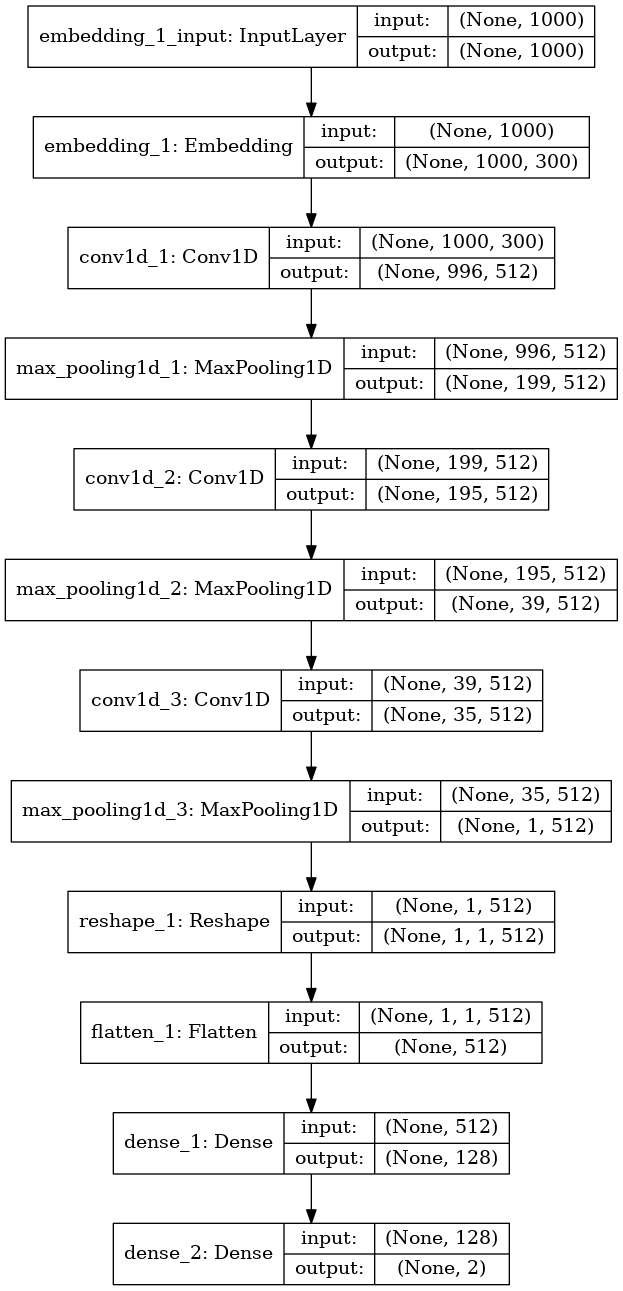

In [0]:
num_class = 2
num_words = 157206
textModel = models.generateTextualModel(num_class, num_words)
plot_model(textModel, to_file='./tutorial/images/textModel.png', show_shapes=True, show_layer_names=True)
display(Image('./tutorial/images/textModel.png'))

### Visual model

We follow the **VGG-network design style**, alligned with the Arandjelovic et al. [3] work , with an **input of 224x244 colour image**, four blocks of conv+conv+pool layers, a flatten layer and two fully connected layers, one with ReLU activation and the last one with softmax activation, whose **output will be the field of science** to which the input belongs. On one hand, the convolutional layers of this architecture work with 3x3 convolutional filters, where the number of filters is doubled in each block (64, 128, 256 and 512), and each one of them is followed by batch normalization and ReLU activation. The max-pooling layers, on the other hand, are 2x2 with stride 2.

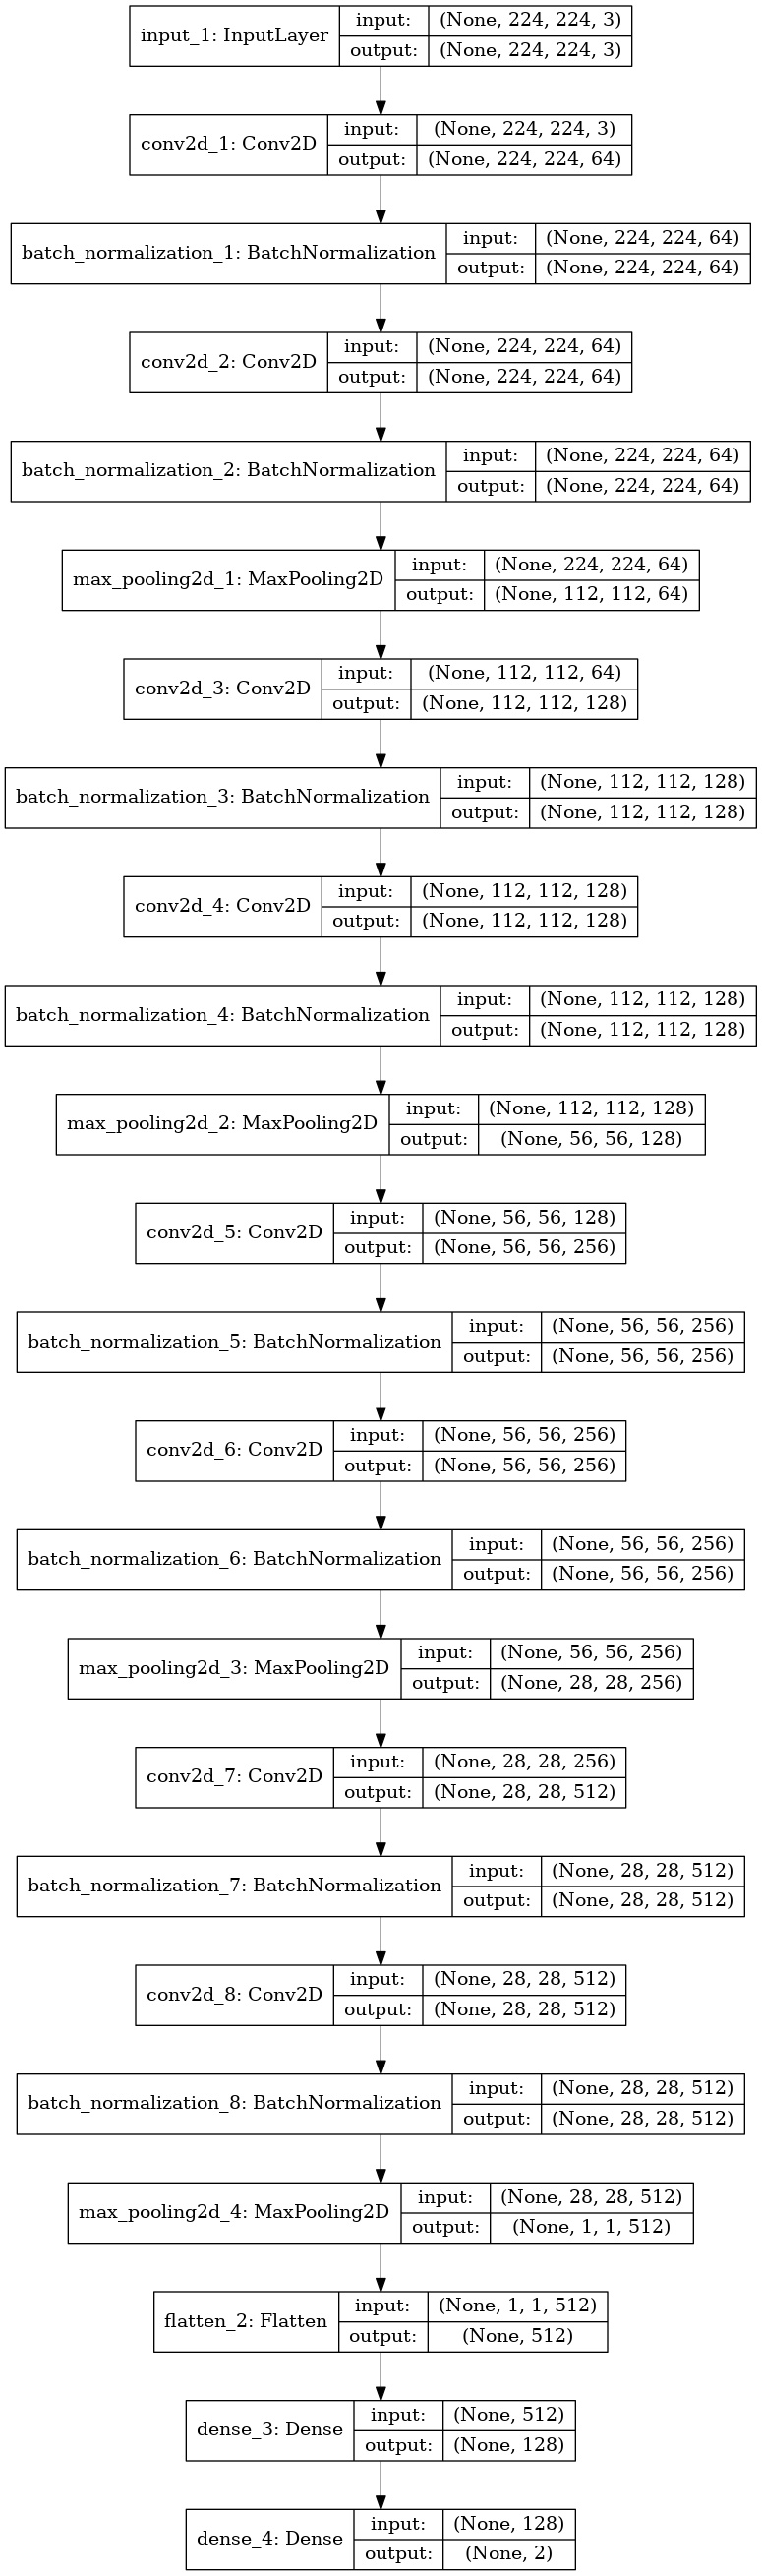

In [0]:
visualModel = models.generateVisualModel(num_class)
plot_model(visualModel, to_file='./tutorial/images/visualModel.png', show_shapes=True, show_layer_names=True)
display(Image('./tutorial/images/visualModel.png'))

### Crossmodal model

For this model, **we concatenate the outputs of the last max-pooling layers of textual and visual CNNs**, as Arandjelovic et al. [3] work shows, and we follow up the architecture with a flatten layer and two fully connected layers, the first one with ReLU activation and the last one with softmax activation, which can lead to **two possible outputs: the figure and the caption correspond or not.**


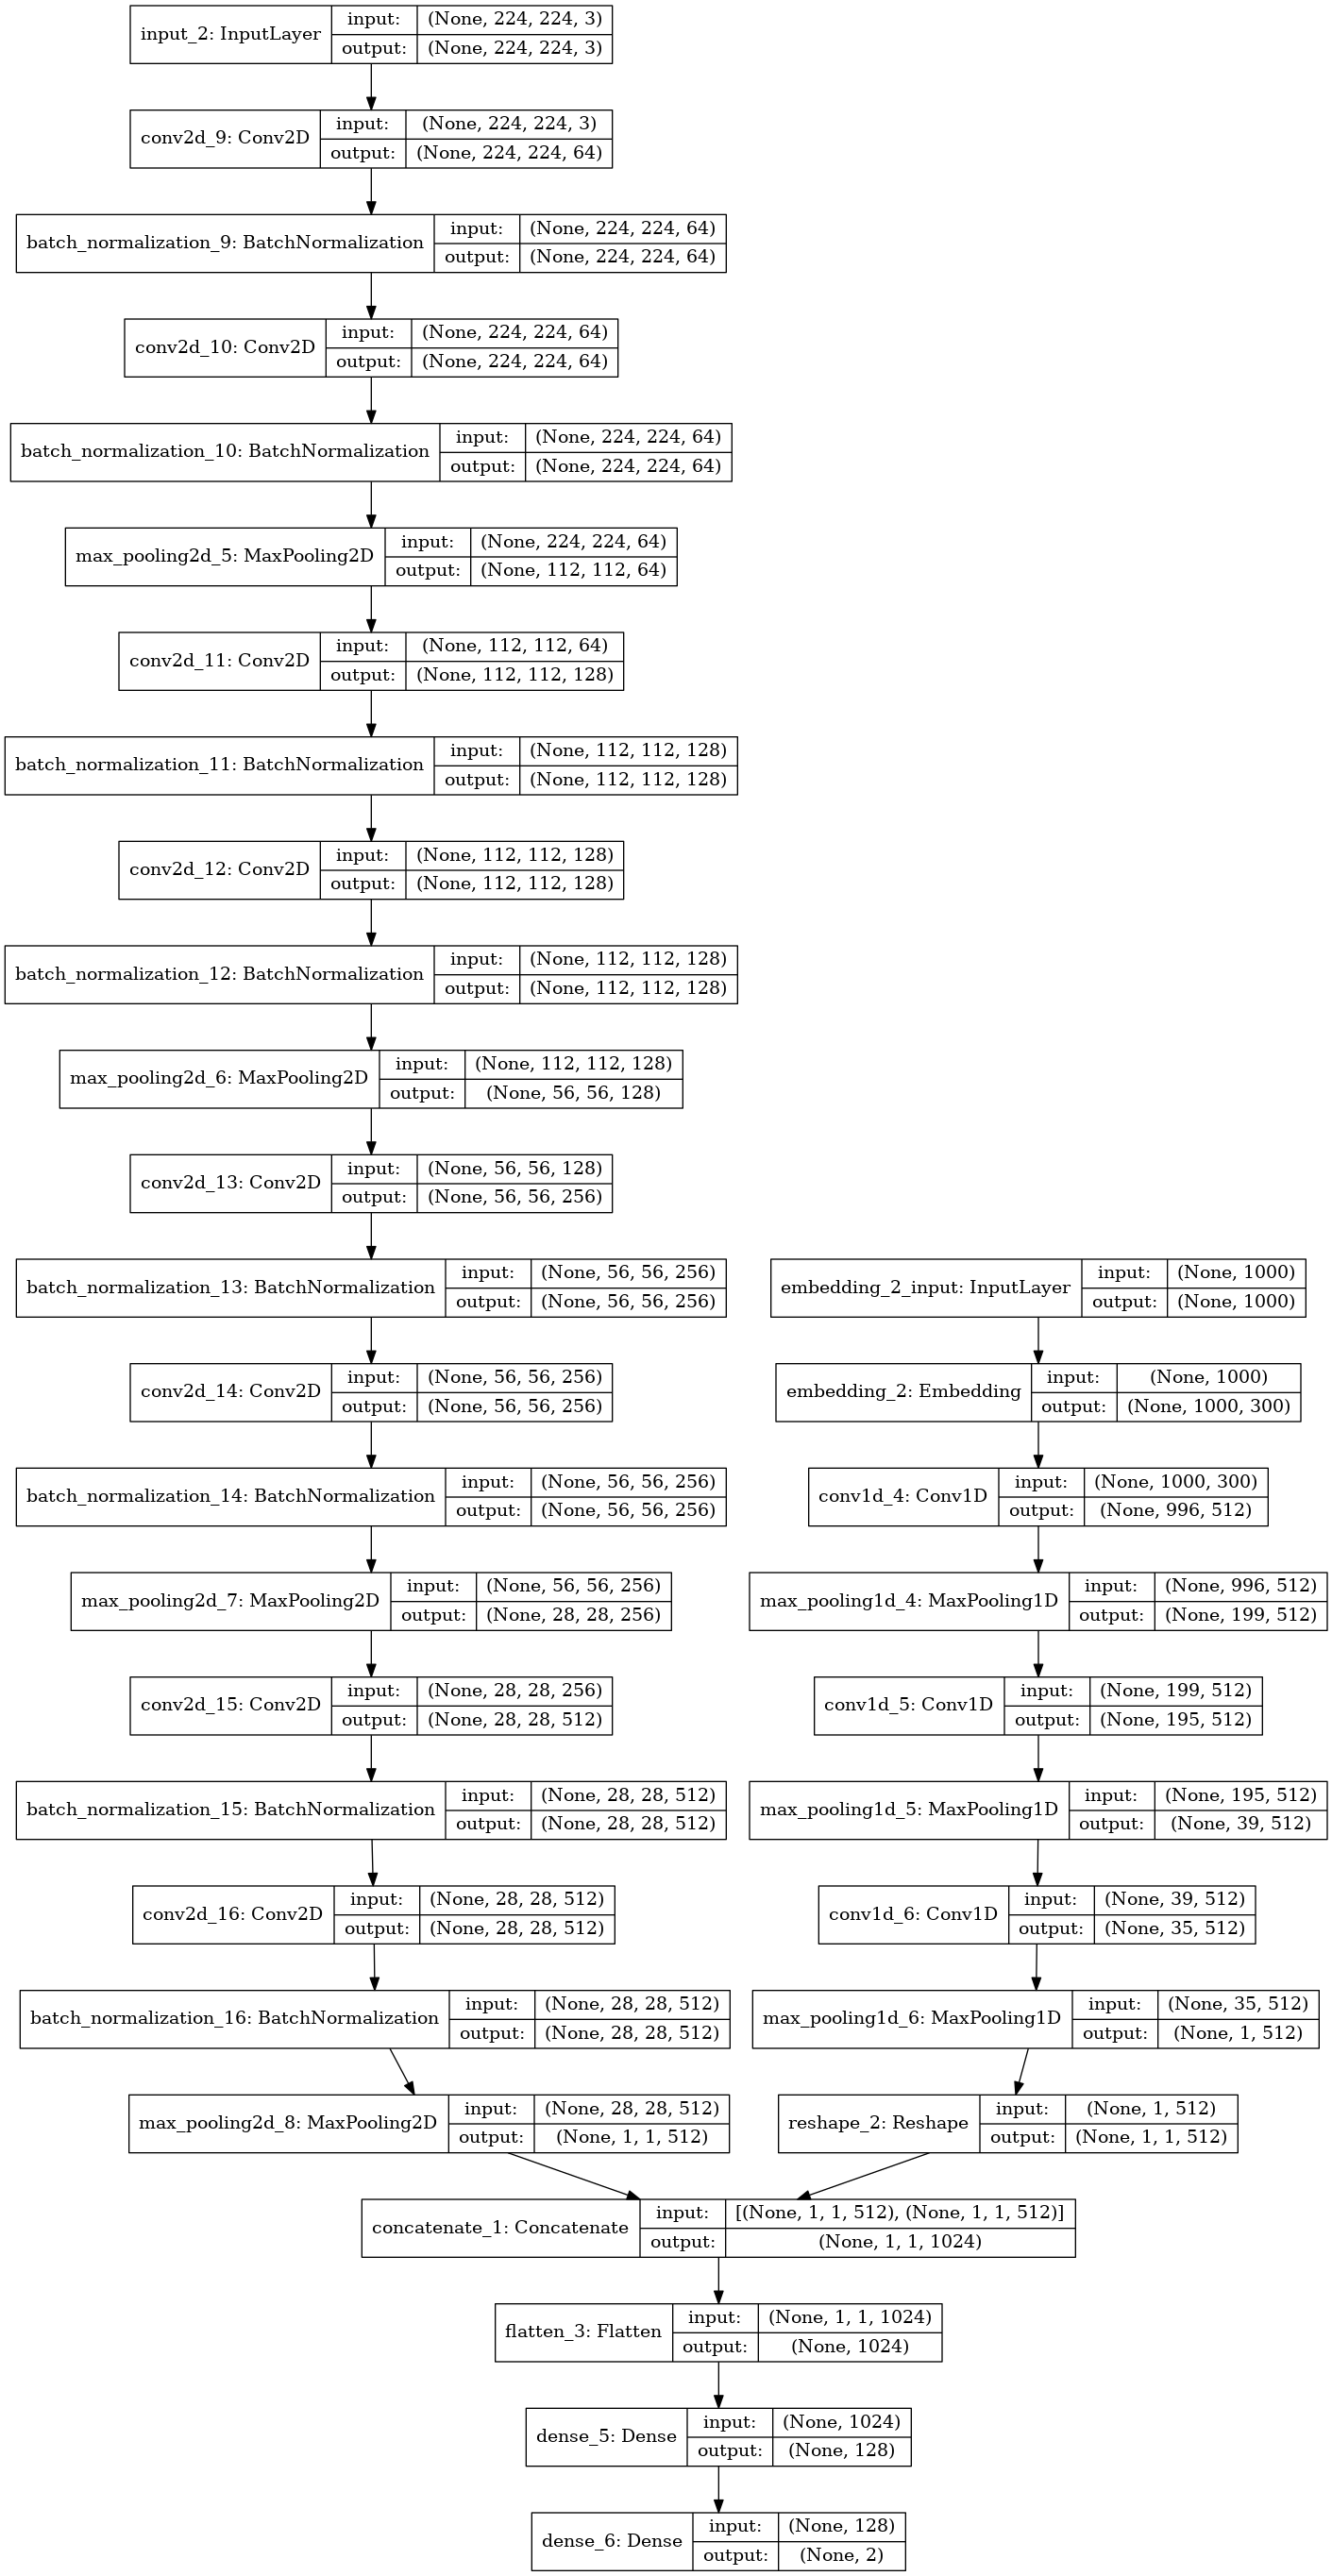

In [0]:
crossModel = models.generateCrossModel(num_class,num_words)
plot_model(crossModel, to_file='./tutorial/images/crossModel.png', show_shapes=True, show_layer_names=True)
display(Image('./tutorial/images/crossModel.png'))

## Experiments

Initially, we grouped several categories in only two: Health Sciences (formed by articles from the SciGraph categories Medical and Health Sciences and Biological Sciences) and Technology Sciences (composed of articles from Mathematical Sciences, Engineering and Information and Computing Sciences). Both have a significant amount of figures, which at the same time are representative of each category. This helped us augment our data by distributing in only two well-represented and balanced categories, showing that our models were actually capable of discerning between broad fields of knowledge. 

For brevity , this notebook does not include the above mentioned experiment and directly addresses a finer-grain categorization task, focused in the following main five categories: 
- **Medical and Health Sciences**
- **Biological Sciences**
- **Mathematical Sciences**
- **Engineering and Information**
- **Computing Sciences**

Albeit, the ones with a more abundant representation in our corpus, the number of figures and articles belonging to these categories is remarkably unbalanced and some of them are conceptually similar to each other. The training of every model used on this research was carried out using cross validation (10-fold), so that it could be checked whether or not there is overfitting in the process. 46,953 articles and 82,396 figures (and captions) were used in each one of the experiments.

### Baseline: Title+Abstract

First, and before running the experiments, we tried to repeat with our data and models the experiment carried out by García and Gómez-Pérez [1] of** categorization of a corpus of scientific articles based on their title and abstract**. Thanks to this baseline, we can check and compare the operation of our textual model with blocks of text that describe the content of the publications more generally than the figures or the subtitles.

In [0]:
num_papers = 4694
experiments.exp_title_abs("5class", num_papers)

Number of images: 4694
Number of classes: 5
146/146 [==============================] - 7s 46ms/step
                                    precision    recall  f1-score   support

       Medical and Health Sciences     0.9481    0.9719    0.9599      3137
Information and Computing Sciences     0.7608    0.7348    0.7476       264
                       Engineering     0.8889    0.6917    0.7780       266
             Mathematical Sciences     0.7964    0.9254    0.8561       630
               Biological Sciences     0.8435    0.5893    0.6939       375

                       avg / total     0.9053    0.9056    0.9022      4672



### Experiment #1: Categorization by figures

With this experiment, we want to evaluate the first part of hypothesis **H1**: can a figure be categorized automatically based on its content?

In [0]:
num_images = 8239
experiments.exp_figures("5class","unimodal", num_images, training=False)

Number of images: 8239
Number of classes: 5
257/257 [==============================] - 104s 406ms/step
                                    precision    recall  f1-score   support

       Medical and Health Sciences     0.8293    0.8827    0.8552      3291
                       Engineering     0.7104    0.5180    0.5991      1473
               Biological Sciences     0.4057    0.2088    0.2757       546
             Mathematical Sciences     0.5595    0.8607    0.6781      1536
Information and Computing Sciences     0.6431    0.4681    0.5418      1378

                       avg / total     0.6983    0.6991    0.6853      8224



### Experiment  #2: Categorization by captions

With this experiment, we want to evaluate the second part of hypothesis **H1**: can a figure be categorized automatically based on the content of its caption? 

In [0]:
num_captions = 8239
experiments.exp_captions("5class","unimodal",num_captions,training=False)

Number of images: 8239
Number of classes: 5
                                    precision    recall  f1-score   support

       Medical and Health Sciences     0.8498    0.8939    0.8713      3271
                       Engineering     0.7513    0.7721    0.7615      1518
               Biological Sciences     0.7423    0.5105    0.6050       570
             Mathematical Sciences     0.7330    0.7148    0.7238      1525
Information and Computing Sciences     0.6607    0.6627    0.6617      1340

                       avg / total     0.7717    0.7740    0.7711      8224



### Experiment #3: Figure-caption association

With this experiment, we want to evaluate the hypothesis **H2** and **H3** (complementarity and knowledge transfer between figure and caption models). As shown above the model is a classifier that given a piece of text and a figure predicts whether or not there is a correspondence between each other.

In [18]:
num_images = 26607
experiments.exp_cross(num_images, training=False)

Number of images: 26607
Number of classes: 2
831/831 [==============================] - 327s 393ms/step
             precision    recall  f1-score   support

          0     0.7924    0.6939    0.7399     13381
          1     0.7246    0.8158    0.7675     13211

avg / total     0.7587    0.7545    0.7536     26592



### Experiment #4: Crossmodal quantitative analysis (figure+caption)

In this experiment, **we ran again the experiments #1 and #2, but using the weights generated in the experiment #3**. The result of this experiment will be studied to check if there is an improvement when categorizing an article based on any of the two modalities (Hypothesis **H4**) and qualitatively, analyzing specific cases of improvement and how the weights have acted of the mixed network as opposed to the unimodal processing, so that we can obtain a more exhaustive analysis of how the crosmodal transmission of knowledge works.

In [0]:
!ls

captions_2clusters_cross.h5	     figures_5class_cross_weights.h5
captions_2clusters_cross_weights.h5  figures_5class.h5
captions_2clusters.h5		     figures_5class_weights.h5
captions_2clusters_weights.h5	     quality2clusters.h5
captions_5class_cross.h5	     quality5class.h5
captions_5class_cross_weights.h5     qualityMix2clusters.h5
captions_5class.h5		     qualityMix5class.h5
captions_5class_weights.h5	     qualityUni2clusters.h5
cross.h5			     qualityUni5class.h5
cross_weights.h5		     sample_data
figures_2clusters_cross.h5	     title_abstract_2clusters.h5
figures_2clusters_cross_weights.h5   title_abstract_2clusters_weights.h5
figures_2clusters.h5		     title_abstract_5class.h5
figures_2clusters_weights.h5	     title_abstract_5class_weights.h5
figures_5class_cross.h5		     tutorial


In [5]:
num_images = 8239
experiments.exp_figures("5class","crossmodal", num_images)

Number of images: 8239
Number of classes: 5
257/257 [==============================] - 91s 353ms/step
                                    precision    recall  f1-score   support

       Medical and Health Sciences     0.7947    0.8534    0.8230      3294
                       Engineering     0.5849    0.4059    0.4792      1493
               Biological Sciences     0.2260    0.1144    0.1519       577
             Mathematical Sciences     0.5002    0.7971    0.6147      1503
Information and Computing Sciences     0.4751    0.3375    0.3947      1357

                       avg / total     0.6102    0.6249    0.6048      8224



In [6]:
num_captions = 8239
experiments.exp_captions("5class","crossmodal", num_captions)

Number of images: 8239
Number of classes: 5
257/257 [==============================] - 11s 43ms/step
                                    precision    recall  f1-score   support

       Medical and Health Sciences     0.8082    0.9347    0.8669      3215
                       Engineering     0.7847    0.7639    0.7742      1508
               Biological Sciences     0.7895    0.4173    0.5460       611
             Mathematical Sciences     0.6930    0.7266    0.7094      1485
Information and Computing Sciences     0.7185    0.5922    0.6492      1405

                       avg / total     0.7664    0.7688    0.7604      8224



### Experiment #5: Crossmodal qualitative analysis (figure+caption)

With this experiment we will examine** specific cases of improvement** and how the weights have acted of the mixed network as opposed to the unimodal processing, so that we can obtain a more exhaustive analysis of how the **crosmodal transmission** of knowledge works. For this purpose, we will generate **heatmaps** to visualize to which sections of this figures the visual neuronal network is paying attention depending on whether it has the weights of the crossmodal analysis or not.

In [17]:
qualitative.getCAM("5class")

Diferencia de 4523: 55.50272464752197(Uni: 0.1274953; Mix: 0.68252254)


TypeError: ignored

## Conclusions


From the results obtained in the experiments above, we can conclude that:

*   **VGG based models** can extract **features of high level** from the figures of a scientific corpus.
*   A figure's **caption** contains enough information to **categorize** it.
*   There is **knowledge transfer between modalities** when performing a cross-modal analysis of figure-caption, with interesting properties e.g. for categorization.

## References

[1] Andrés García, José Manuel Gómez-Pérez (2018). Not just about size – A Study on the Role of Distributed Word Representations in the Analysis of Scientific Publications: https://arxiv.org/abs/1804.01772

[2] Fabian Both, Steffen Thoma, Achim Rettinger (2017). Cross-modal Knowledge Transfer: Improving the Word Embedding of Apple by Looking at Oranges: http://www.aifb.kit.edu/images/0/00/K_CAP_2017_CrossModalKnowledgeTransfer_PrePub.pdf

[3] Relja Arandjelovic, Andrew Zisserman (2017). Look, Listen and Learn: https://arxiv.org/abs/1705.08168

[4] Yoon Kim (2014). Convolutional Neural Networks for Sentence Classification: https://arxiv.org/abs/1408.5882